In [5]:
%matplotlib inline
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Maps
import geopandas as gpd
import geodatasets
from matplotlib.patches import Patch, Wedge

# ---------- Fixed paths (relative to this notebook) ----------
DATA = Path("../data/processed")
MORT_CSV   = DATA / "mortalities.csv"
VOLGA_XLSX = DATA / "volga_discharge.xlsx"
WIND_CSV   = DATA / "wind_caspian_2010_24.csv"

print("Using:\n ", MORT_CSV, "\n ", VOLGA_XLSX, "\n ", WIND_CSV)

# ---------- Load & clean mortalities ----------
df = pd.read_csv(MORT_CSV).copy()

# lat/lon (support commas as decimals)
for col in ["lat", "lon"]:
    df[col] = (
        df[col].astype(str)
               .str.replace(",", ".", regex=False)
               .str.replace(r"[^0-9\.\-]", "", regex=True)
               .replace({"": np.nan})
               .astype(float)
    )

# count
df["count"] = pd.to_numeric(
    df.get("count", np.nan)
      if "count" in df.columns else np.nan,
    errors="coerce"
)

# date/year/month
if "date" in df.columns:
    df["date"]  = pd.to_datetime(df["date"], errors="coerce")
    df["year"]  = df["date"].dt.year
    df["month"] = df["date"].dt.month
else:
    df["year"]  = pd.to_numeric(df["year"], errors="coerce")
    df["month"] = pd.to_numeric(df.get("month", np.nan), errors="coerce")

# primary cause (optional)
df["primary_cause"] = df.get("primary_cause", "unknown").astype(str).str.strip().str.lower()

# drop rows without coords
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# combined events by site (rounded), year+month
df_combined = (
    df.assign(lat=df["lat"].round(4), lon=df["lon"].round(4))
      .groupby(["year", "month", "lat", "lon"], as_index=False, dropna=False)
      .agg(count=("count", "sum"))
)

# season (helper)
def month_to_season(m):
    if pd.isna(m): return "Unknown"
    m = int(m)
    return ("Winter" if m in (12,1,2) else
            "Spring" if m in (3,4,5) else
            "Summer" if m in (6,7,8) else
            "Fall"   if m in (9,10,11) else "Unknown")
df["season"] = df["month"].apply(month_to_season)

# ---------- Load Volga discharge (year + 12 monthly columns) ----------
volga = pd.read_excel(VOLGA_XLSX)
volga = volga.rename(columns={volga.columns[0]: "year"})  # first col is year
month_cols = list(volga.columns[1:13])                    # next 12 are months
volga_long = volga.melt(id_vars="year", value_vars=month_cols,
                        var_name="month_col", value_name="discharge")
month_map = {col: i+1 for i, col in enumerate(month_cols)}
volga_long["month"] = volga_long["month_col"].map(month_map)
volga_avg = volga_long.groupby("month", as_index=False)["discharge"].mean()

# ---------- Load wind (2010–2024) and build monthly climatology ----------
wind = pd.read_csv(WIND_CSV, parse_dates=["time"])  # expects columns: time + wind column
# pick wind column by common names; adjust here if your header differs
wind_col = next((c for c in ["area_mean_smoothed","wind_sm","wind","speed"] if c in wind.columns), None)
if wind_col is None:
    raise KeyError("Wind CSV must have one of: area_mean_smoothed / wind_sm / wind / speed")

wind_monthly = (
    wind.set_index("time")[wind_col]
        .resample("MS").mean()
        .reset_index()
)
wind_monthly["month"] = wind_monthly["time"].dt.month
wind_clim = wind_monthly.groupby("month", as_index=False)[wind_col].mean()
wind_label = f"Wind ({wind_col}, 2010–2024 avg)"

print("Loaded rows:",
      f"mortalities={len(df)}  combined={len(df_combined)}  volga={len(volga_long)}  wind={len(wind_monthly)}")


Using:
  ../data/processed/mortalities.csv 
  ../data/processed/volga_discharge.xlsx 
  ../data/processed/wind_caspian_2010_24.csv
Loaded rows: mortalities=68  combined=34  volga=396  wind=180


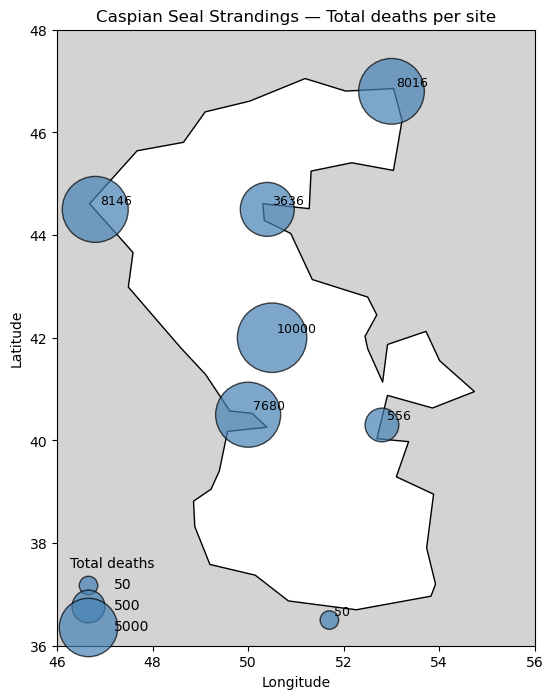

In [6]:
# Aggregate totals per site
agg_sites = (
    df.groupby(["lat", "lon"], as_index=False)
      .agg(total_deaths=("count", "sum"),
           n_events=("count", "count"))
)

def bubble_area(count, base=25.0):
    if pd.isna(count) or count <= 0:
        return base
    return base * math.sqrt(float(count))

sizes = agg_sites["total_deaths"].apply(bubble_area)

# Map window
lon_min, lon_max = 46, 56
lat_min, lat_max = 36, 48

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
region = world.cx[lon_min:lon_max, lat_min:lat_max]

fig, ax = plt.subplots(figsize=(8, 8))
region.plot(ax=ax, color="lightgrey", edgecolor="black")

ax.scatter(
    agg_sites["lon"], agg_sites["lat"],
    s=sizes, color="steelblue", alpha=0.7, edgecolor="black"
)

for _, r in agg_sites.iterrows():
    ax.text(r["lon"]+0.1, r["lat"]+0.1, f"{int(r['total_deaths'])}",
            fontsize=9, color="black")

ax.set_xlim(lon_min, lon_max); ax.set_ylim(lat_min, lat_max)
ax.set_title("Caspian Seal Strandings — Total deaths per site")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

legend_vals = [50, 500, 5000]
handles = [plt.scatter([], [], s=bubble_area(v), color="steelblue",
                       alpha=0.7, edgecolor="black", label=str(v))
           for v in legend_vals]
ax.legend(handles=handles, title="Total deaths", loc="lower left", frameon=False)
plt.show()


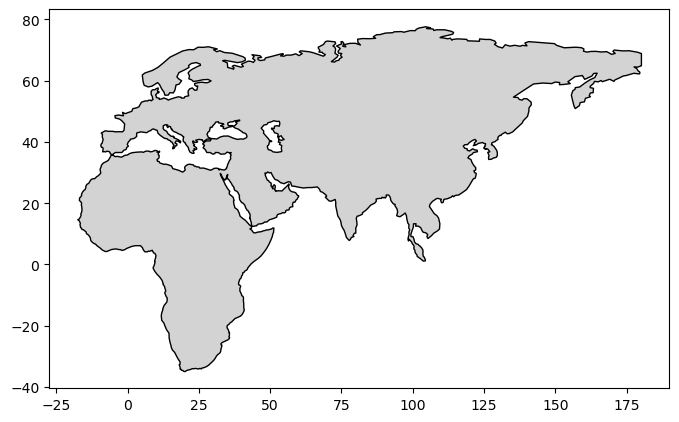

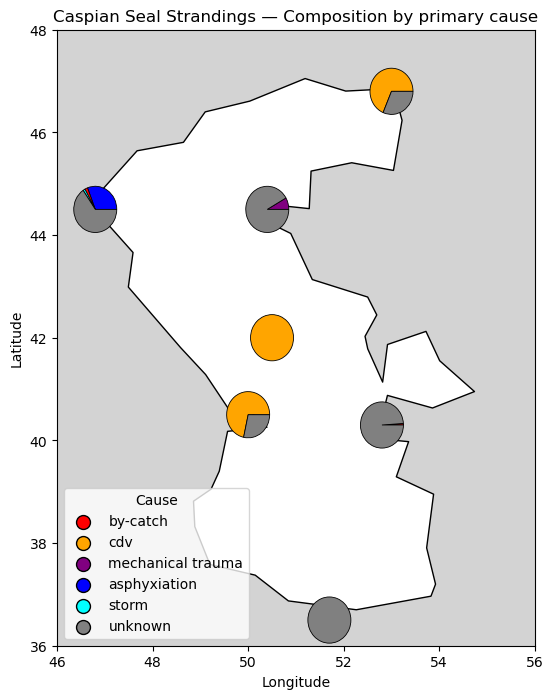

In [8]:
agg_cause = (
    df.groupby(["lat", "lon", "primary_cause"], as_index=False)
      .agg(total_deaths=("count", "sum"))
)
agg_total = (
    df.groupby(["lat", "lon"], as_index=False)
      .agg(site_total=("count", "sum"))
)
merged = pd.merge(agg_cause, agg_total, on=["lat", "lon"])

cause_colors = {
    "by-catch": "red",
    "cdv": "orange",
    "mechanical trauma": "purple",
    "asphyxiation": "blue",
    "storm": "cyan",
    "unknown": "grey",
}

def draw_pie(ax, ratios, X, Y, size=0.45, colors=None):
    start = 0.0
    for frac, color in zip(ratios, colors):
        if frac <= 0: continue
        wedge = Wedge(center=(X, Y), r=size,
                      theta1=start, theta2=start + 360.0*frac,
                      facecolor=color, edgecolor="black", linewidth=0.6)
        ax.add_patch(wedge)
        start += 360.0*frac

fig, ax = plt.subplots(figsize=(8, 8))
region.plot(ax=ax, color="lightgrey", edgecolor="black")  # from Cell 2

for (lat, lon), site in merged.groupby(["lat", "lon"]):
    total = float(site["site_total"].iloc[0]) if site["site_total"].notna().any() else 0.0
    if total <= 0: continue
    fracs = (site["total_deaths"] / total).tolist()
    cols  = [cause_colors.get(c, "white") for c in site["primary_cause"]]
    draw_pie(ax, fracs, lon, lat, size=0.45, colors=cols)

ax.set_xlim(lon_min, lon_max); ax.set_ylim(lat_min, lat_max)
ax.set_title("Caspian Seal Strandings — Composition by primary cause")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

for cause, col in cause_colors.items():
    ax.scatter([], [], c=col, label=cause, s=100, edgecolor="black")
ax.legend(title="Cause", loc="lower left")
plt.show()


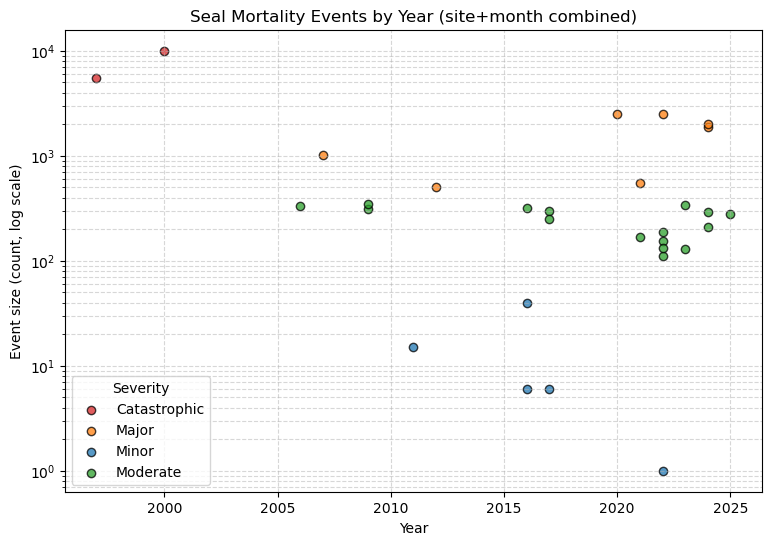

In [9]:
df_ev = df_combined.dropna(subset=["year", "count"]).copy()
df_ev = df_ev[df_ev["count"] > 0]

def grade_event(n):
    return ("Minor" if n < 50 else
            "Moderate" if n < 500 else
            "Major" if n < 5000 else
            "Catastrophic")

df_ev["grade"] = df_ev["count"].apply(grade_event)
grade_colors = {"Minor":"tab:blue","Moderate":"tab:green","Major":"tab:orange","Catastrophic":"tab:red"}

plt.figure(figsize=(9, 6))
for g, sub in df_ev.groupby("grade"):
    plt.scatter(sub["year"], sub["count"], alpha=0.75, edgecolor="k",
                label=g, color=grade_colors[g])

plt.yscale("log")
plt.title("Seal Mortality Events by Year (site+month combined)")
plt.xlabel("Year"); plt.ylabel("Event size (count, log scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend(title="Severity")
plt.show()


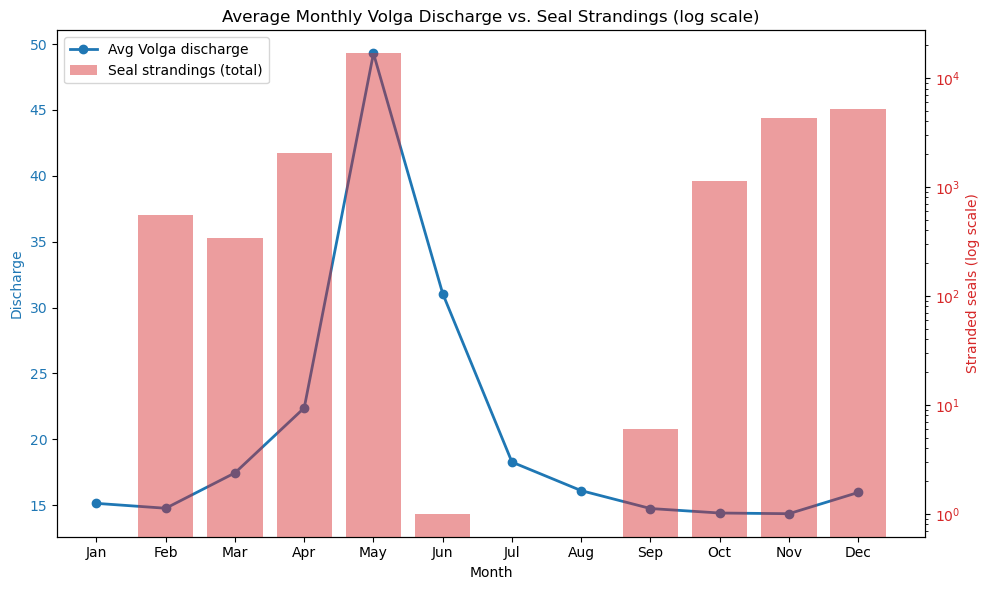

In [10]:
df_month_totals = (
    df.dropna(subset=["month", "count"])
      .groupby("month", as_index=False)["count"]
      .sum()
      .sort_values("month")
)

fig, ax1 = plt.subplots(figsize=(10, 6))

p1, = ax1.plot(
    volga_avg["month"], volga_avg["discharge"],
    marker="o", linewidth=2.0, color="tab:blue", label="Avg Volga discharge"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Discharge", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

ax2 = ax1.twinx()
ax2.bar(df_month_totals["month"], df_month_totals["count"],
        color="tab:red", alpha=0.45, label="Seal strandings (total)")
ax2.set_ylabel("Stranded seals (log scale)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale("log")

bar_proxy = Patch(facecolor="tab:red", alpha=0.45, label="Seal strandings (total)")
ax1.legend([p1, bar_proxy], ["Avg Volga discharge", "Seal strandings (total)"],
           loc="upper left")

plt.title("Average Monthly Volga Discharge vs. Seal Strandings (log scale)")
fig.tight_layout()
plt.show()


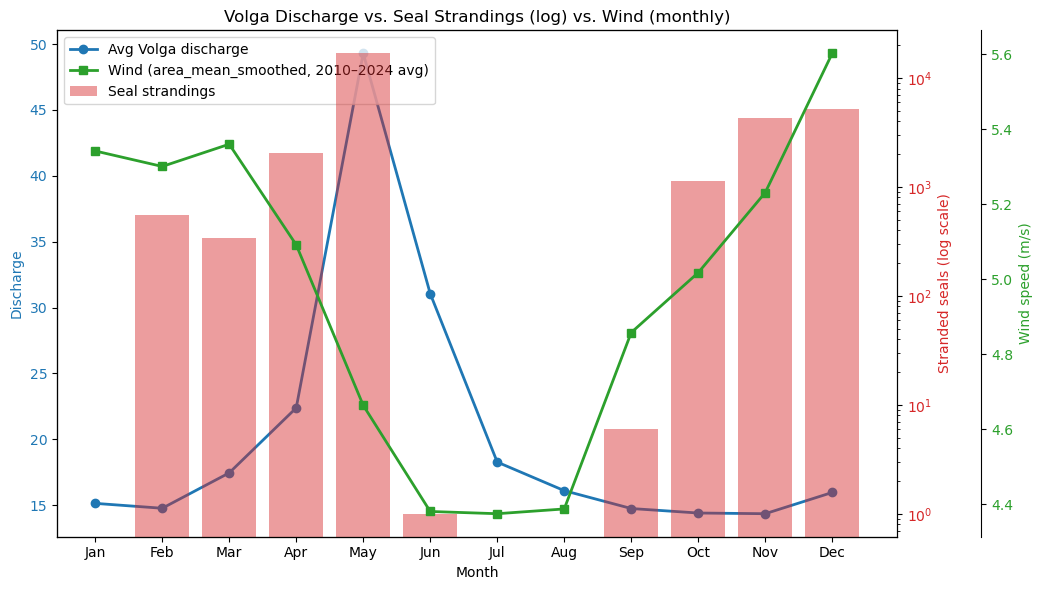

In [12]:
fig, ax1 = plt.subplots(figsize=(10.5, 6))

# Discharge (left)
p1, = ax1.plot(
    volga_avg["month"], volga_avg["discharge"],
    marker="o", linewidth=2.0, color="tab:blue",
    label="Avg Volga discharge"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Discharge", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# Strandings (right, log)
ax2 = ax1.twinx()
bar_proxy = Patch(facecolor="tab:red", alpha=0.45, label="Seal strandings")
ax2.bar(
    df_month_totals["month"], df_month_totals["count"],
    color="tab:red", alpha=0.45
)
ax2.set_ylabel("Stranded seals (log scale)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale("log")

# Wind monthly climatology (offset right)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.10))
ax3.set_frame_on(True); ax3.patch.set_visible(False)
p3, = ax3.plot(
    wind_clim["month"], wind_clim[wind_col],
    marker="s", linestyle="-", linewidth=2.0, color="tab:green",
    label=wind_label
)
ax3.set_ylabel("Wind speed (m/s)", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

# Legend
handles = [p1, p3, bar_proxy]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("Volga Discharge vs. Seal Strandings (log) vs. Wind (monthly)")
fig.tight_layout()
plt.show()
